In [1]:
import glob
import os
from os import path

import earthpy.mask as em
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
import rioxarray as rxr
import xarray as xr
from numpy.random import default_rng
from rasterio import features
from rasterio import merge
from rasterio import plot
from rasterio.crs import CRS
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterstats import zonal_stats
from shapely.geometry import mapping
from shapely.geometry import shape

# Directories

In [2]:
# Define temp directory
input_dir = "data/raw/"# input data directory
dest_dir = "data/temp/"# output data directory

# REMOVE invisible DS_Store file (mac issue) - do it ONCE only
list_dir = ['data/output/.DS_Store',
            'data/output/prep_regr_tabs/.DS_Store',
            'data/output/regressions/.DS_Store',
            'data/output/regressions/controlled_Climate/.DS_Store',
            'data/output/regressions/controlled_WatSanEdu/.DS_Store',
            'data/output/regressions/GWR/.DS_Store',
            'data/output/regressions/NON_controlled/.DS_Store',
            'data/output/regressions/sp_autocorr/.DS_Store',
            'data/raw/.DS_Store',
            'data/raw/dhs/.DS_Store',
            'data/raw/dhs/CIGE61FL/.DS_Store',
            'data/raw/dhs/CIKR62DT_children/.DS_Store',
            'data/raw/osm/.DS_Store',
            'data/raw/osm/input/.DS_Store',
            'data/raw/osm/output/.DS_Store',
            'data/raw/raster_to_clip/.DS_Store',
            'data/temp/.DS_Store']

for f_dir in list_dir:
    if os.path.exists(f_dir)==True:
        os.remove(f_dir)

# Environmental data: define AOI & clip

In [3]:
# Define directory of source files
src_dir = "data/raw/raster_to_clip/"# input data directory

### Clip geotiff files

In [4]:
# Clipping shape
crop_extent = gpd.read_file(path.join(input_dir, "gadm36_CIV_0.shp"))

# For loop: clip all rasters based on "crop_extent" (select by file extension)

src_filepaths = glob.glob(path.join(src_dir,"*.tif"))# list all .tif files in input data dir
src_filepaths = src_filepaths+glob.glob(path.join(src_dir,"*.TIF"))# add all .TIF files to input list

for src_filepath in src_filepaths:
    print(src_filepath)
    src_basename = path.basename(src_filepath)
    dest_filepath = path.join(dest_dir, src_basename)
    with rxr.open_rasterio(src_filepath) as src:
        src_clipped = src.rio.clip(crop_extent.geometry.apply(mapping),crop_extent.crs)
    src_clipped.rio.to_raster(path.join(dest_dir,src_basename))

data/raw/raster_to_clip/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_13_10.tif
data/raw/raster_to_clip/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_13_11.tif
data/raw/raster_to_clip/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2012-v2.0.7.tif
data/raw/raster_to_clip/BlackMarble_2012_B1_geo_gray.tif
data/raw/raster_to_clip/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_12_11.tif
data/raw/raster_to_clip/civ_ppp_2012_UNadj.tif
data/raw/raster_to_clip/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_12_10.tif


### Merge clipped tif files : GHS files only (4 files required to cover all Ivorian territory)

METADATA (FROM MODEL):  {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 15388, 'height': 12579, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(30.0, 0.0, -750000.0,
       0.0, -30.0, 900000.0)}
METADATA TRANSFORMED:  {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 22651, 'height': 23874, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(30.0, 0.0, -957270.0,
       0.0, -30.0, 1202250.0)}
REMOVING:  data/temp/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_13_10.tif
REMOVING:  data/temp/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_13_11.tif
REMOVING:  data/temp/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_12_11.tif
REMOVING:  data/temp/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_12_10.tif


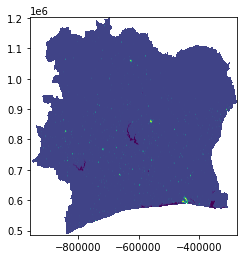

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 22651, 'height': 23874, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(30.0, 0.0, -957270.0,
       0.0, -30.0, 1202250.0)}
REMOVING:  data/temp/GHS_merged.tif


In [5]:
# MERGE CLIPPED RASTER files (GHS files only)

# Set input & output directories
input_filepaths = glob.glob(path.join(dest_dir,"GHS_BUILT*"))# list of raster files requiring merge
dest_filepath = path.join(dest_dir, "GHS_merged.tif")

# MERGE RASTERS
merged_arr, merged_transform = rasterio.merge.merge(input_filepaths)
# NOTE: merged_transform provides Affine attributes for metadata

# SET RASTER METADATA
rastermodel = rasterio.open(input_filepaths[1])# example from input list gives metadata
meta = rastermodel.meta.copy()
print("METADATA (FROM MODEL): ",meta)
# Update metadata of merged raster
meta.update(transform=merged_transform, width=merged_arr.shape[2], height=merged_arr.shape[1])
print("METADATA TRANSFORMED: ",meta)

# SAVE to GeoTiff
with rasterio.open(dest_filepath, 'w', **meta) as dest:
    dest.write(merged_arr)

# Remove input files (that are now obsolete)
src_filepaths = glob.glob(path.join(dest_dir,"GHS_BUILT*"))# list of input files to be removed
for src_filepath in src_filepaths:
    print("REMOVING: ",src_filepath)
    os.remove(src_filepath)

# Check GHS final output
with rasterio.open(dest_filepath) as src:
    plot.show(src)
    print(src.meta)
    
# Transform masked raster's CRS to EPSG 4326

dst_crs = 'EPSG:4326'

with rasterio.open(path.join(dest_dir,"GHS_merged.tif")) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(path.join(dest_dir,"GHS_merged_epsg4326.tif"), 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

# Remove temp raster
print("REMOVING: ",path.join(dest_dir,"GHS_merged.tif"))
os.remove(path.join(dest_dir,"GHS_merged.tif"))

### Open and "slice" climate data (.nc format) for area of interest

In [6]:
nc_data_lst = [path.join(src_dir,"TerraClimate_tmax_2012.nc"),
               path.join(src_dir,"TerraClimate_ppt_2012.nc")]

# Save clipped rasters (extracted from nc dataset)
for data_path in nc_data_lst:
    # Open nc data file
    print("opening",data_path)
    with xr.open_dataset(data_path) as file_nc:
        cl_data_xr = file_nc.rio.write_crs(file_nc.rio.crs, inplace=True)
    var = path.basename(data_path).split('_')[1]
    # Replace fill values (32768) by NaNs
    cl_data_xr = cl_data_xr.where(cl_data_xr[var] != -32768.)
    cl_data_xr = cl_data_xr.where(cl_data_xr[var] != 32768.)
    # Set CRS to EPSG 4326
    print("reprojecting...")
    cl_data_xr4326 = cl_data_xr.rio.reproject("epsg:4326")
    # Slice the data spatially using specific lat/lon values (bounding box)
    # Côte d'Ivoire's bbox (lat/long values entered manually):
    cl_data_xr_sel = cl_data_xr4326[var].sel(y=slice(11,4),x=slice(-9,-2))
    # Export to geotiff
    # Exclude attributes (required step to export to raster)
    print("preparing export...")
    cl_data_xr_sel.attrs = {}
    file_path = path.join(dest_dir,path.basename(data_path).split('.')[0]+'_bboxciv.tif')
    cl_data_xr_sel.rio.to_raster(file_path)

opening data/raw/raster_to_clip/TerraClimate_tmax_2012.nc
reprojecting...
preparing export...
opening data/raw/raster_to_clip/TerraClimate_ppt_2012.nc
reprojecting...
preparing export...


In [7]:
# Calculate MEAN values

# SET "sliced" data directories:
data_lst = [path.join(dest_dir,"TerraClimate_tmax_2012_bboxciv.tif"),
            path.join(dest_dir,"TerraClimate_ppt_2012_bboxciv.tif")]

# Import geotiffs as arrays

arr_lst_t = []
arr_lst_p = []

for data in data_lst:
    tiff = rasterio.open(data)
    n_bands = tiff.meta['count']# for both datasets, n_bands=12 (monthly observations)
    # import geotiff's band i as array
    for i in list(range(n_bands+1)[1:]):
        if data == data_lst[0]:
            globals()[str('tmax_arr'+str(i))] = tiff.read(i)
            arr_lst_t = arr_lst_t+[str('tmax_arr'+str(i))]
        elif data == data_lst[1]:
            globals()[str('ppt_arr'+str(i))] = tiff.read(i)
            arr_lst_p = arr_lst_p+[str('ppt_arr'+str(i))]
        else:
            print('error')
        
print("imported : ", str(arr_lst_t))
print("imported : ", str(arr_lst_p))

# Calculate mean values

# Geotiff 1 ('tmax')

mean_lst = []

for y in list(range(tmax_arr1.shape[0])):
    mean_vals = (tmax_arr1[y]+tmax_arr2[y]+tmax_arr3[y]+tmax_arr4[y]+
                 tmax_arr5[y]+tmax_arr6[y]+tmax_arr7[y]+tmax_arr8[y]+
                 tmax_arr9[y]+tmax_arr10[y]+tmax_arr11[y]+tmax_arr12[y])/n_bands
    mean_lst = mean_lst+[mean_vals]

mean_arr = np.array(mean_lst)

# Replace invalid values by nan:
mean_arr[mean_arr==-32768.] = np.nan

print("Shape: ",mean_arr.shape)
print("Min mean 'tmax': ",np.nanmin(mean_arr))
print("Max mean 'tmax': ",np.nanmax(mean_arr))
print(mean_arr)

# Geotiff 2 ('ppt')

mean_lst = []

for y in list(range(ppt_arr1.shape[0])):
    mean_vals2 = (ppt_arr1[y]+ppt_arr2[y]+ppt_arr3[y]+ppt_arr4[y]+
                  ppt_arr5[y]+ppt_arr6[y]+ppt_arr7[y]+ppt_arr8[y]+
                  ppt_arr9[y]+ppt_arr10[y]+ppt_arr11[y]+ppt_arr12[y])/n_bands
    mean_lst = mean_lst+[mean_vals2]

mean_arr2 = np.array(mean_lst)

# Replace invalid values by nan:
mean_arr2[mean_arr2==32768.] = np.nan

print("Shape: ",mean_arr2.shape)
print("Min mean 'ppt': ",np.nanmin(mean_arr2))
print("Max mean 'ppt': ",np.nanmax(mean_arr2))
print(mean_arr2)

# EXPORT ARRAY in RASTER FORMAT

# GET METADATA (from original raster file, defined in cell above)
ref_tiff = rasterio.open(data_lst[0])
meta_mean_vals = ref_tiff.meta.copy() # COPY METADATA from reference data (raster)
meta_mean_vals.update(dtype='float32', count=1) # dtype = type of data // count = n° of bands

# WRITE RASTER FILE
# tmax
with rasterio.open(path.join(dest_dir,path.basename(data_lst[0]).split('.')[0]+'_MEAN.tif'), 'w', **meta_mean_vals) as dst:
    dst.write(mean_arr, 1) # 1 = chosen band for export
# ppt
with rasterio.open(path.join(dest_dir,path.basename(data_lst[1]).split('.')[0]+'_MEAN.tif'), 'w', **meta_mean_vals) as dst:
    dst.write(mean_arr2, 1) # 1 = chosen band for export 

imported :  ['tmax_arr1', 'tmax_arr2', 'tmax_arr3', 'tmax_arr4', 'tmax_arr5', 'tmax_arr6', 'tmax_arr7', 'tmax_arr8', 'tmax_arr9', 'tmax_arr10', 'tmax_arr11', 'tmax_arr12']
imported :  ['ppt_arr1', 'ppt_arr2', 'ppt_arr3', 'ppt_arr4', 'ppt_arr5', 'ppt_arr6', 'ppt_arr7', 'ppt_arr8', 'ppt_arr9', 'ppt_arr10', 'ppt_arr11', 'ppt_arr12']
Shape:  (168, 168)
Min mean 'tmax':  27.262499
Max mean 'tmax':  35.065002
[[34.8325   34.953335 35.065002 ... 33.85333  33.850834 33.780834]
 [34.829166 34.8975   35.009167 ... 33.809998 33.810833 33.8175  ]
 [34.7625   34.895    34.975834 ... 33.734997 33.72167  33.77    ]
 ...
 [      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]]
Shape:  (168, 168)
Min mean 'ppt':  67.29166666666667
Max mean 'ppt':  236.725
[[121.36666667 120.65       119.56666667 ...  89.34166667  89.14166667
   90.78333333]
 [122.64166667 121.

In [8]:
# Calculate standard deviation values

# Geotiff 1 ('tmax')

std_lst = []

for y in list(range(tmax_arr1.shape[0])):
    std_vals = np.sqrt(((np.square(tmax_arr1[y]-mean_arr[y]))+
                   (np.square(tmax_arr2[y]-mean_arr[y]))+
                   (np.square(tmax_arr3[y]-mean_arr[y]))+
                   (np.square(tmax_arr4[y]-mean_arr[y]))+
                   (np.square(tmax_arr5[y]-mean_arr[y]))+
                   (np.square(tmax_arr6[y]-mean_arr[y]))+
                   (np.square(tmax_arr7[y]-mean_arr[y]))+
                   (np.square(tmax_arr8[y]-mean_arr[y]))+
                   (np.square(tmax_arr9[y]-mean_arr[y]))+
                   (np.square(tmax_arr10[y]-mean_arr[y]))+
                   (np.square(tmax_arr11[y]-mean_arr[y]))+
                   (np.square(tmax_arr12[y]-mean_arr[y])))/(n_bands-1))
    std_lst = std_lst+[std_vals]

std_arr = np.array(std_lst)

print("Shape: ",std_arr.shape)
print("Min variance 'tmax': ",np.nanmin(std_arr))
print("Max variance 'tmax': ",np.nanmax(std_arr))
print(std_arr)

# Geotiff 2 ('ppt')

std_lst = []

for y in list(range(ppt_arr1.shape[0])):
    std_vals2 = np.sqrt(((np.square(ppt_arr1[y]-mean_arr2[y]))+
                   (np.square(ppt_arr2[y]-mean_arr2[y]))+
                   (np.square(ppt_arr3[y]-mean_arr2[y]))+
                   (np.square(ppt_arr4[y]-mean_arr2[y]))+
                   (np.square(ppt_arr5[y]-mean_arr2[y]))+
                   (np.square(ppt_arr6[y]-mean_arr2[y]))+
                   (np.square(ppt_arr7[y]-mean_arr2[y]))+
                   (np.square(ppt_arr8[y]-mean_arr2[y]))+
                   (np.square(ppt_arr9[y]-mean_arr2[y]))+
                   (np.square(ppt_arr10[y]-mean_arr2[y]))+
                   (np.square(ppt_arr11[y]-mean_arr2[y]))+
                   (np.square(ppt_arr12[y]-mean_arr2[y])))/(n_bands-1))
    std_lst = std_lst+[std_vals2]

std_arr2 = np.array(std_lst)

print("Shape: ",std_arr2.shape)
print("Min std 'ppt': ",np.nanmin(std_arr2))
print("Max std 'ppt': ",np.nanmax(std_arr2))
print(std_arr2)

# EXPORT ARRAY in RASTER FORMAT

# tmax
with rasterio.open(path.join(dest_dir,path.basename(data_lst[0]).split('.')[0]+'_STD.tif'), 'w', **meta_mean_vals) as dst:
    dst.write(std_arr, 1) # 1 = chosen band for export
# ppt
with rasterio.open(path.join(dest_dir,path.basename(data_lst[1]).split('.')[0]+'_STD.tif'), 'w', **meta_mean_vals) as dst:
    dst.write(std_arr2, 1) # 1 = chosen band for export

Shape:  (168, 168)
Min variance 'tmax':  0.96135724
Max variance 'tmax':  3.05879
[[2.989257  2.9310102 2.8966362 ... 2.9989374 2.9973004 3.0114796]
 [2.99395   2.9415398 2.8857687 ... 2.9763067 2.9869668 3.003008 ]
 [2.980915  2.955345  2.917164  ... 2.9722364 2.9868827 2.9892688]
 ...
 [      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]]
Shape:  (168, 168)
Min std 'ppt':  40.598865486462536
Max std 'ppt':  185.9827906261515
[[130.43739936 129.93669438 128.6928149  ... 103.05287662 103.2251155
  103.82270581]
 [131.38419345 130.50526519 129.53029451 ... 103.3092192  103.69099052
  103.93096011]
 [131.95576021 131.27235481 130.09227028 ... 103.65533907 104.1337816
  104.62633801]
 ...
 [         nan          nan          nan ...          nan          nan
           nan]
 [         nan          nan          nan ...          nan          nan


In [9]:
# Calculate accumulated rainfall (mm):

# Geotiff 2 ('ppt')

sum_lst = []

for y in list(range(ppt_arr1.shape[0])):
    sum_vals = (ppt_arr1[y]+ppt_arr2[y]+ppt_arr3[y]+ppt_arr4[y]+
                  ppt_arr5[y]+ppt_arr6[y]+ppt_arr7[y]+ppt_arr8[y]+
                  ppt_arr9[y]+ppt_arr10[y]+ppt_arr11[y]+ppt_arr12[y])
    sum_lst = sum_lst+[sum_vals]

sum_arr = np.array(sum_lst)

# Replace invalid values by nan:
sum_arr[sum_arr==393216.] = np.nan

print("Shape: ",sum_arr.shape)
print("Min ac. 'ppt': ",np.nanmin(sum_arr))
print("Max ac. 'ppt': ",np.nanmax(sum_arr))
print(sum_arr)

# EXPORT ARRAY in RASTER FORMAT

# ppt
with rasterio.open(path.join(dest_dir,path.basename(data_lst[1]).split('.')[0]+'_acPPT.tif'), 'w', **meta_mean_vals) as dst:
    dst.write(sum_arr, 1) # 1 = chosen band for export

Shape:  (168, 168)
Min ac. 'ppt':  807.5
Max ac. 'ppt':  2840.7
[[1456.4 1447.8 1434.8 ... 1072.1 1069.7 1089.4]
 [1471.7 1459.6 1447.7 ... 1078.5 1082.2 1088.9]
 [1481.9 1471.5 1458.4 ... 1094.7 1097.5 1103.8]
 ...
 [   nan    nan    nan ...    nan    nan    nan]
 [   nan    nan    nan ...    nan    nan    nan]
 [   nan    nan    nan ...    nan    nan    nan]]


# Environmental data: preprocessing landscape metrics

### Categorized vector grid from land cover raster (ESACCI-LC, 300x300 m)
NOTE: each "pixel" from ESACCI landcover dataset classified as urban will be re-classified according to density and illumination (steps beelow)

In [10]:
# Set input
input_filepath = path.join(dest_dir,"ESACCI-LC-L4-LCCS-Map-300m-P1Y-2012-v2.0.7.tif")

# Get raster model's shape
with rasterio.open(input_filepath) as src:
    print(src.meta)
    # import src band 1 as array
    src_arr1 = src.read(1)
    # set unique values to array (except 'no data' pixels)
    rng = default_rng()# call range function
    numbers = rng.choice((src.meta["height"]*src.meta["width"]),# max value: ncol x nrow
                         size=(src.meta["height"],src.meta["width"]),# size: ncol, nrow
                         replace=False)# do not replace: unique only
            
    # replace 'no data' value in "numbers" (because it is contained in the range defined above)
    numbers = np.where(numbers==(src.meta["nodata"]),# find 'no data' value
                       (src.meta["height"]*src.meta["width"])+1,# replace by new unique value
                       numbers)
    
    print(numbers)
    print("new array's dtype:", numbers.dtype)
    # change new array's dtype to original dtype 
    numbers = numbers.astype('int32')
    print("changed new array's dtype to:", numbers.dtype)
    
    # Set new array with unique values
    src_arr2 = np.where(src_arr1!=(src.meta["nodata"]),
                        numbers,
                        src_arr1)
    print(src_arr2)
    print(type(src_arr2))
    print("Check 'No Data' values (diff. must be 0): diff = ",
          np.count_nonzero(src_arr1==(src.meta["nodata"]))-np.count_nonzero(src_arr2==(src.meta["nodata"])))
    
    # generate new src with same shape but different values than original src
    source_poly = rasterio.features.shapes(src_arr2,
                                           mask=None,
                                           connectivity=4,
                                           transform=src.meta["transform"])
    print(source_poly)

# Turn output into GeoDataFrame
source_poly_gdf = gpd.GeoDataFrame([(shape(geom), val) for geom, val in source_poly], columns=['geometry', 'ID'])

# Exclude 'No Data' pixels from GeoDataFrame
source_poly_gdf_clean = source_poly_gdf[source_poly_gdf.ID!=src.meta["nodata"]]
print(source_poly_gdf_clean)
print(type(source_poly_gdf_clean))

# Add attributes
source_poly_gdf_clean["LandCover"] = src_arr1[src_arr1!=src.meta["nodata"]].reshape(-1,order='C')
print(source_poly_gdf_clean)

# Extract built up pixels
built_up_gdf = source_poly_gdf_clean[source_poly_gdf_clean.LandCover==190]# class '190' = built-up

# Save built up pixels to Shapefile format
built_up_gdf.to_file(path.join(dest_dir, "built_up.shp"))

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 2198, 'height': 2295, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0027777777777780025, 0.0, -8.599999999986286,
       0.0, -0.002777777777778, 10.736111111104782)}
[[4530204 2564140 4692814 ... 2926889 1727280 1874929]
 [3844205 1229961 3274677 ... 2167587 2329951 3985335]
 [2777728  279547 2187161 ... 1841720 2871933 1921081]
 ...
 [3343118 1023895 1509779 ...  722964 3812020 2788324]
 [1212385 3025395  930849 ... 4245010 4972655 2329632]
 [ 572357 1888196  139136 ...  762953 2975401  136897]]
new array's dtype: int64
changed new array's dtype to: int32
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
<class 'numpy.ndarray'>
Check 'No Data' values (diff. must be 0): diff =  0
<generator object shapes at 0x7f92b0463a50>
                                                  geometry         ID
0        POLYGON ((-6.26111 10.73611, -6.26111 1

/Users/vitor/miniconda3/envs/LS_Metrics/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


### Zonal stats for built-up pixels (300x300m)

In [11]:
# ZONAL STATS in built up pixels (1): night lights intensity (from NASA)

# Set reference polygon layer for zonal statistics (spatial aggregation units, i.e. 100x100m grid)
aggr_poly = path.join(path.join(dest_dir, "built_up.shp"))
aggr_poly_gdf = gpd.read_file(path.join(dest_dir, "built_up.shp"))

# Set night lights data source
input_filepath = path.join(dest_dir,"BlackMarble_2012_B1_geo_gray.tif")

# Zonal statistics for demographic density
zs = zonal_stats(aggr_poly,# polygon shapefile defined above
                 input_filepath,# raster file defined above
                 all_touched=True,# include all pixels touching geometry in zonal_stats
                 stats="count median") # result will be in 'dictionary' format
# NOTE: the ref. polygon shp and the raster file have different grids;
# so that 1 square in 'aggr_poly' may overlap several pixels from 'input_filepath'
# therefore, we collect the median value of these pixels

# SET RASTER STATS: from DICTIONARY to DATAFRAME (w/ pandas)
zs_df = pd.DataFrame(zs)

# rename columns
zs_df = zs_df.rename(columns={'count':'nl_count',
                              'median': 'nl_med'})

# JOIN TABLES (zonal raster stats results to geodataframe)
polygons_gdf_join = aggr_poly_gdf.join(zs_df)
print("Joined data: polygons_gdf_join")
print("Number of 'No Data' areas in polygons_gdf_join :", polygons_gdf_join[polygons_gdf_join.nl_count==0].shape[0])

/Users/vitor/miniconda3/envs/LS_Metrics/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


Joined data: polygons_gdf_join
Number of 'No Data' areas in polygons_gdf_join : 0


In [12]:
# ZONAL STATS in built up pixels (2): Demographic densities from WorldPop (UN-adjusted)

# Set density data source
input_filepath = path.join(dest_dir,"civ_ppp_2012_UNadj.tif")

# Zonal statistics for demographic density
zs = zonal_stats(aggr_poly,# polygon shapefile defined previously (100x100m grid)
                 input_filepath,# raster file defined above
                 all_touched=True,# include all pixels touching geometry in zonal_stats
                 stats="count median") # result will be in 'dictionary' format
# NOTE: the ref. polygon shp and the raster file have different grids;
# so that 1 square in 'aggr_poly' may overlap several pixels from 'input_filepath'
# therefore, we collect the median value of these pixels

# SET RASTER STATS: from DICTIONARY to DATAFRAME (w/ pandas)
zs_df = pd.DataFrame(zs)

# rename columns
zs_df = zs_df.rename(columns={'count':'den_count',
                              'median':'den_med'})

# JOIN TABLES (zonal raster stats to geodataframe)
polygons_gdf_join2 = aggr_poly_gdf.join(zs_df)
print("Joined data: polygons_gdf_join2")
print("Number of 'No Data' areas in polygons_gdf_join2 :", polygons_gdf_join2[polygons_gdf_join2.den_count==0].shape[0])

Joined data: polygons_gdf_join2
Number of 'No Data' areas in polygons_gdf_join2 : 4


In [13]:
# RE-CLASSIFICATION of BUILT UP AREAS

# Recalculate classes: calibrate thresholds manually (by quantiles)
# >> Verifications done in QGIS, based on locations of slums in Abidjan (high-density/low-illumination) 

# Set "nl_class" attributes
polygons_gdf_join["nl_class"]=''
mask = polygons_gdf_join.nl_med>0
polygons_gdf_join.nl_class[(polygons_gdf_join.nl_med>=0)&
                           (polygons_gdf_join.nl_count>0)] = '1'# NO LIGHT (==0)
polygons_gdf_join.nl_class[polygons_gdf_join.nl_med>=
                           np.nanquantile(polygons_gdf_join.nl_med[mask],0.10)] = '2'# Low-light threshold
polygons_gdf_join.nl_class[polygons_gdf_join.nl_med>=
                           np.nanquantile(polygons_gdf_join.nl_med[mask],0.50)] = '3'# Mid-light threshold
polygons_gdf_join.nl_class[polygons_gdf_join.nl_med>=
                           np.nanquantile(polygons_gdf_join.nl_med[mask],0.90)] = '4'# High-light threshold

# Set "den_class" attributes
polygons_gdf_join2["den_class"]=''
mask = polygons_gdf_join2.den_med>0
polygons_gdf_join2.den_class[(polygons_gdf_join2.den_med>=0)&
                             (polygons_gdf_join2.den_count>0)] = '1'# UNINHABITED (==0)
polygons_gdf_join2.den_class[polygons_gdf_join2.den_med>=
                             np.nanquantile(polygons_gdf_join2.den_med[mask],0.10)] = '2'# Very Low-den. threshold
polygons_gdf_join2.den_class[polygons_gdf_join2.den_med>=
                             np.nanquantile(polygons_gdf_join2.den_med[mask],0.50)] = '3'# Low to High den. threshold
polygons_gdf_join2.den_class[polygons_gdf_join2.den_med>=
                             np.nanquantile(polygons_gdf_join2.den_med[mask],0.90)] = '4'# Very High-den. threshold

# -----------------
# RE-CLASSIFICATION

# Join GDFs with night lights and density values ('polygons_gdf_join' & 'polygons_gdf_join2')
df = polygons_gdf_join.copy()# start from a copy of df (for more safety)
polygons_gdf_join_f = df.join(polygons_gdf_join2[['den_count',
                                                  'den_med',
                                                  'den_class']])

# Create "r_class" column
polygons_gdf_join_f["r_class"] = ""
# Calculate fields
polygons_gdf_join_f["r_class"] = '190'+polygons_gdf_join_f.den_class.astype('str')+polygons_gdf_join_f.nl_class.astype('str')
print(polygons_gdf_join_f)

# Create "PrecAr" column: 'precarious areas' are dense but poorly illuminated
polygons_gdf_join_f["PrecAr"] = ""
# Classify wheter precarious or not
polygons_gdf_join_f["PrecAr"][polygons_gdf_join_f["den_class"]>polygons_gdf_join_f["nl_class"]] = 1
polygons_gdf_join_f["PrecAr"][polygons_gdf_join_f["den_class"]<=polygons_gdf_join_f["nl_class"]] = 0

# -----------------
# Check new classes
print("List & count of unique 'r_class' values :")
print(pd.DataFrame.transpose(pd.DataFrame(np.unique(list(polygons_gdf_join_f.r_class),return_counts=True))))
print("List & count of unique 'PrecAr' values :")
print(pd.DataFrame.transpose(pd.DataFrame(np.unique(list(polygons_gdf_join_f.PrecAr),return_counts=True))))

# Check count of new classes
print("TOTAL 'r_class' values (must be ",
      polygons_gdf_join_f.shape[0],
      ") :",
      np.sum(pd.DataFrame.transpose(pd.DataFrame(np.unique(list(polygons_gdf_join_f.r_class),return_counts=True)))[1]))

print("TOTAL 'PrecAr' values (must be ",
      polygons_gdf_join_f.shape[0],
      ") :",
      np.sum(pd.DataFrame.transpose(pd.DataFrame(np.unique(list(polygons_gdf_join_f.PrecAr),return_counts=True)))[1]))

# Save GDF in Shapefile format
polygons_gdf_join_f.to_file(path.join(dest_dir, "built_up_BtClass.shp"))

              ID  LandCover  \
0      2065271.0        190   
1      2783802.0        190   
2      4277221.0        190   
3      2158438.0        190   
4      1293363.0        190   
...          ...        ...   
15423  3795203.0        190   
15424  3292154.0        190   
15425  2980427.0        190   
15426  3593485.0        190   
15427  3136311.0        190   

                                                geometry  nl_count  nl_med  \
0      POLYGON ((-6.41111 10.48889, -6.40833 10.48889...         4   127.5   
1      POLYGON ((-6.40833 10.48889, -6.40556 10.48889...         2   176.5   
2      POLYGON ((-6.40556 10.48889, -6.40278 10.48889...         4   176.5   
3      POLYGON ((-6.41667 10.48611, -6.41389 10.48611...         2    90.5   
4      POLYGON ((-6.41389 10.48611, -6.41111 10.48611...         4    90.5   
...                                                  ...       ...     ...   
15423  POLYGON ((-7.36111 4.41389, -7.35833 4.41389, ...         4   101.5   
154

<ipython-input-13-c6c9e3d15d96>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  polygons_gdf_join.nl_class[(polygons_gdf_join.nl_med>=0)&
<ipython-input-13-c6c9e3d15d96>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  polygons_gdf_join.nl_class[polygons_gdf_join.nl_med>=
<ipython-input-13-c6c9e3d15d96>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  polygons_gdf_join.nl_class[polygons_gdf_join.nl_med>=
<ipython-input-13-c6c9e3d15d

eliminating features with erroneous r_class (len<5))...
no. of eliminated features (len(r_class)<5) : 4
r_class values :
['19011', '19012', '19013', '19014', '19021', '19022', '19023', '19024', '19031', '19032', '19033', '19034', '19042', '19043', '19044']
source metadata : 
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 2198, 'height': 2295, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0027777777777780025, 0.0, -8.599999999986286,
       0.0, -0.002777777777778, 10.736111111104782)}
new metadata : 
{'driver': 'GTiff', 'dtype': 'int32', 'nodata': 0.0, 'width': 2198, 'height': 2295, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0027777777777780025, 0.0, -8.599999999986286,
       0.0, -0.002777777777778, 10.736111111104782)}
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
mask_arr :
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 

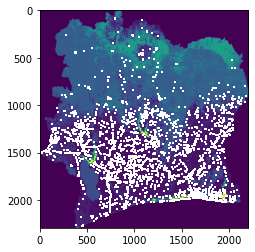

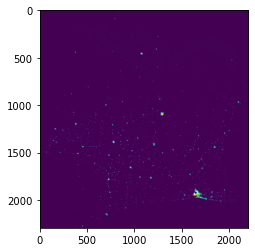

source metadata : 
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 2198, 'height': 2295, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0027777777777780025, 0.0, -8.599999999986286,
       0.0, -0.002777777777778, 10.736111111104782)}
new metadata : 
{'driver': 'GTiff', 'dtype': 'int32', 'nodata': 0.0, 'width': 2198, 'height': 2295, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0027777777777780025, 0.0, -8.599999999986286,
       0.0, -0.002777777777778, 10.736111111104782)}


In [14]:
## RE-CLASSIFIED BUILT-UP AREAS (for pylandstats analyses)

# From GDF back to raster : built-up areas, 16 classes (4x4 levels of density & illumination)

# Make copy of gdf for array
polygons_gdf2arr_0 = gpd.read_file(path.join(dest_dir, "built_up_BtClass.shp"))
# Exclude erroneous r_classPB (i.e. those missing density or night light values)
print("eliminating features with erroneous r_class (len<5))...")
polygons_gdf2arr = polygons_gdf2arr_0[polygons_gdf2arr_0["r_class"].str.len()>4]
print("no. of eliminated features (len(r_class)<5) :",
      polygons_gdf2arr_0.shape[0]-polygons_gdf2arr.shape[0])

# Prepare array for raster export
r_cl_list = list(pd.DataFrame.transpose(pd.DataFrame(np.unique(list(polygons_gdf2arr.r_class),return_counts=True)))[0])
print("r_class values :")
print(r_cl_list)

# GET Raster format
ref_raster = rasterio.open(path.join(dest_dir,
                                     "ESACCI-LC-L4-LCCS-Map-300m-P1Y-2012-v2.0.7.tif"))

ref_meta = ref_raster.meta
print("source metadata : ")
print(ref_meta)
ref_meta.update(dtype='int32')
print("new metadata : ")
print(ref_meta)

# From gdf to array, selected column (band in raster) = "r_class"
arr = features.rasterize(((geom, int(val)) for geom, val in zip(polygons_gdf2arr["geometry"], polygons_gdf2arr["r_class"])),
                         out_shape=ref_raster.shape,
                         fill=ref_meta["nodata"],
                         transform=ref_meta["transform"],
                         dtype=ref_meta["dtype"])

print(arr)

# WRITE TEMP RASTER FILE
with rasterio.open(path.join(dest_dir,"built_up_rclass16.tif"), 'w', **ref_meta) as dst:
    dst.write(arr, 1)
    
# INSERT new built-up class values (16) in land cover raster (replace original values)

# Get input data
arr = rasterio.open(path.join(dest_dir,"ESACCI-LC-L4-LCCS-Map-300m-P1Y-2012-v2.0.7.tif")).read(1)
mask_arr = rasterio.open(path.join(dest_dir,"built_up_rclass16.tif")).read(1)
print("mask_arr :")
print(mask_arr)
vals_list = list(pd.DataFrame.transpose(pd.DataFrame(np.unique(mask_arr,return_counts=True)))[0])
vals_list.remove(ref_raster.nodata)
print("vals_list :")
print(vals_list)

# Call the earthpy mask function using pixel QA layer
landcover_masked = em.mask_pixels(arr, mask_arr,
                                  vals=vals_list).astype('int32')

# Check result
plot.show(landcover_masked)

# Get replacement pixels
landcover_repl_pix = rxr.open_rasterio(path.join(dest_dir,"built_up_rclass16.tif"),
                                       masked=True).squeeze().astype('int32')

# Get the mask layer from the new land cover (built-up) data
mask = landcover_masked.mask

# Copy the new land cover data to a new array
# (optional step, only to keep the original array)
landcover_masked_copy = np.copy(landcover_masked)

# Assign new pixel values to array
landcover_masked_copy[mask] = landcover_repl_pix.values[mask]

# Check result
plot.show(landcover_masked_copy)

# WRITE RASTER FILE w/ 16 landcover classes

# GET Raster format
ref_raster = rasterio.open(path.join(dest_dir,
                                     "ESACCI-LC-L4-LCCS-Map-300m-P1Y-2012-v2.0.7.tif"))
ref_meta = ref_raster.meta
print("source metadata : ")
print(ref_meta)
print("new metadata : ")
ref_meta.update(dtype='int32')
print(ref_meta)

# Update array's dtype
landcover_masked_copy = landcover_masked_copy.astype(ref_meta['dtype'])

# Save raster
with rasterio.open(path.join(dest_dir,"ESACCI-LC-L4-LCCS-Map-300m-P1Y-2012-v2.0.7_rclass16.tif"), 'w', **ref_meta) as dst:
    dst.write(landcover_masked_copy, 1)

# Remove temp raster
os.remove(path.join(dest_dir,"built_up_rclass16.tif"))

eliminating features with erroneous r_class (len<5))...
no. of eliminated features (len(r_class)<5) : 4
PrecAr values :
['0', '1']
source metadata : 
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 2198, 'height': 2295, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0027777777777780025, 0.0, -8.599999999986286,
       0.0, -0.002777777777778, 10.736111111104782)}
new metadata : 
{'driver': 'GTiff', 'dtype': 'int32', 'nodata': 0.0, 'width': 2198, 'height': 2295, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0027777777777780025, 0.0, -8.599999999986286,
       0.0, -0.002777777777778, 10.736111111104782)}
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
mask_arr :
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
vals_list :
[1]


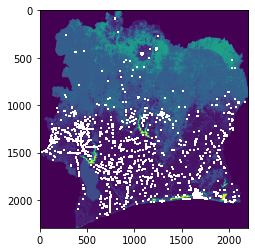

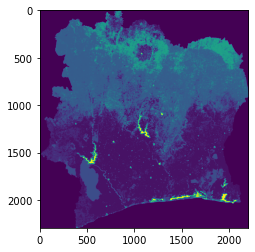

source metadata : 
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 2198, 'height': 2295, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0027777777777780025, 0.0, -8.599999999986286,
       0.0, -0.002777777777778, 10.736111111104782)}
new metadata : 
{'driver': 'GTiff', 'dtype': 'int32', 'nodata': 0.0, 'width': 2198, 'height': 2295, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0027777777777780025, 0.0, -8.599999999986286,
       0.0, -0.002777777777778, 10.736111111104782)}


In [15]:
## RE-CLASSIFIED BUILT-UP AREAS, type 2 (for 2nd round of pylandstats analyses)

# From GDF back to raster : built-up areas, 2 classes ('precarious' X 'non precarious')

# Make copy of gdf for array
polygons_gdf2arr_0 = gpd.read_file(path.join(dest_dir, "built_up_BtClass.shp"))
# Exclude erroneous r_classPB (i.e. those missing density or night light values)
print("eliminating features with erroneous r_class (len<5))...")
polygons_gdf2arr = polygons_gdf2arr_0[polygons_gdf2arr_0["r_class"].str.len()>4]
print("no. of eliminated features (len(r_class)<5) :",
      polygons_gdf2arr_0.shape[0]-polygons_gdf2arr.shape[0])

# Prepare array for raster export
r_cl_list = list(pd.DataFrame.transpose(pd.DataFrame(np.unique(list(polygons_gdf2arr.PrecAr),return_counts=True)))[0])
print("PrecAr values :")
print(r_cl_list)

# GET Raster format
ref_raster = rasterio.open(path.join(dest_dir,
                                     "ESACCI-LC-L4-LCCS-Map-300m-P1Y-2012-v2.0.7.tif"))

ref_meta = ref_raster.meta
print("source metadata : ")
print(ref_meta)
ref_meta.update(dtype='int32')
print("new metadata : ")
print(ref_meta)

# From gdf to array, selected column (band in raster) = "PrecAr"
arr = features.rasterize(((geom, int(val)) for geom, val in zip(polygons_gdf2arr["geometry"], polygons_gdf2arr["PrecAr"])),
                         out_shape=ref_raster.shape,
                         fill=ref_meta["nodata"],
                         transform=ref_meta["transform"],
                         dtype=ref_meta["dtype"])

print(arr)

# WRITE TEMP RASTER FILE
with rasterio.open(path.join(dest_dir,"built_up_rclass2.tif"), 'w', **ref_meta) as dst:
    dst.write(arr, 1)
    
# INSERT new built-up class values (2) in land cover raster (replace original values)

# Get input data
arr = rasterio.open(path.join(dest_dir,"ESACCI-LC-L4-LCCS-Map-300m-P1Y-2012-v2.0.7.tif")).read(1)
mask_arr = rasterio.open(path.join(dest_dir,"built_up_rclass2.tif")).read(1)
print("mask_arr :")
print(mask_arr)
vals_list = list(pd.DataFrame.transpose(pd.DataFrame(np.unique(mask_arr,return_counts=True)))[0])
vals_list.remove(ref_raster.nodata)
print("vals_list :")
print(vals_list)

# Call the earthpy mask function using pixel QA layer
landcover_masked = em.mask_pixels(arr, mask_arr,
                                  vals=vals_list).astype('int32')

# Check result
plot.show(landcover_masked)

# Get replacement pixels
landcover_repl_pix = rxr.open_rasterio(path.join(dest_dir,"built_up_rclass2.tif"),
                                       masked=True).squeeze().astype('int32')

# Get the mask layer from the new land cover (built-up) data
mask = landcover_masked.mask

# Copy the new land cover data to a new array
# (optional step, only to keep the original array)
landcover_masked_copy = np.copy(landcover_masked)

# Assign new pixel values to array
landcover_masked_copy[mask] = landcover_repl_pix.values[mask]

# Check result
plot.show(landcover_masked_copy)

# WRITE RASTER FILE w/ 2 landcover classes

# GET Raster format
ref_raster = rasterio.open(path.join(dest_dir,
                                     "ESACCI-LC-L4-LCCS-Map-300m-P1Y-2012-v2.0.7.tif"))
ref_meta = ref_raster.meta
print("source metadata : ")
print(ref_meta)
print("new metadata : ")
ref_meta.update(dtype='int32')
print(ref_meta)

# Update array's dtype
landcover_masked_copy = landcover_masked_copy.astype(ref_meta['dtype'])

# Save raster
with rasterio.open(path.join(dest_dir,"ESACCI-LC-L4-LCCS-Map-300m-P1Y-2012-v2.0.7_rclassPrec.tif"), 'w', **ref_meta) as dst:
    dst.write(landcover_masked_copy, 1)

# Remove temp raster
os.remove(path.join(dest_dir,"built_up_rclass2.tif"))

### Extract WorldPop pixels located within built-up areas only
NOTE: This will allow to calculate median density specifically in built-up areas, for each buffer zone

In [16]:
# load mask geometries
dest_filepath = path.join(dest_dir, "built_up_BtClass.shp")
with fiona.open(dest_filepath, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

# set masked raster output path
out_filepath = path.join(dest_dir,"civ_ppp_2012_UNadj_masked.tif")

# Get WorldPop raster
input_filepath = path.join(dest_dir,"civ_ppp_2012_UNadj.tif")

# Mask raster    
with rasterio.open(input_filepath) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta
    
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

# Write raster
with rasterio.open(out_filepath, "w", **out_meta) as dest:
    dest.write(out_image)

### Extract built-up areas classified by epoch (from GHS dataset)
NOTE: This will allow to determine buffer zones with most recent/old built-up areas

In [17]:
# Get input data

input_filepath = path.join(dest_dir,"GHS_merged_epsg4326.tif")

with rasterio.open(input_filepath) as src:
    print(src.meta)
    # import src band 1 as array
    src_arr1 = src.read(1) 
    source_poly = rasterio.features.shapes(src_arr1,
                                           mask=(src_arr1>=3),# '3' = from 2000-2014
                                           connectivity=4,
                                           transform=src.meta["transform"])
    print(source_poly)

# Turn output into GeoDataFrame
source_poly_gdf = gpd.GeoDataFrame([(shape(geom), val) for geom, val in source_poly], columns=['geometry', 'Code'])

# Exclude 'No Data' pixels from GeoDataFrame
source_poly_gdf_clean = source_poly_gdf[source_poly_gdf.Code!=src.meta["nodata"]]
print(source_poly_gdf_clean)

# Make copy of gdf for array
polygons_gdf2arr = source_poly_gdf_clean

# GET Raster format
ref_raster = rasterio.open(path.join(dest_dir,
                                     "GHS_merged_epsg4326.tif"))
ref_meta = ref_raster.meta
print("source metadata : ")
print(ref_meta)

# From gdf to array, selected column (band in raster) = "r_class"
arr = features.rasterize(((geom, int(val)) for geom, val in zip(polygons_gdf2arr["geometry"], polygons_gdf2arr["Code"])),
                         out_shape=ref_raster.shape,
                         fill=0,
                         transform=ref_meta["transform"],
                         dtype=ref_meta["dtype"])

print(arr)

# Write raster
with rasterio.open(path.join(dest_dir,"GHS_merged_epsg4326_BuiltAllEpochs.tif"), 'w', **ref_meta) as dst:
    dst.write(arr, 1)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 22761, 'height': 23769, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00026819304878461395, 0.0, -8.599302720290943,
       0.0, -0.00026819304878461395, 10.736602837140381)}
<generator object shapes at 0x7f920d062510>
                                                 geometry  Code
0       POLYGON ((-6.32476 10.70576, -6.32476 10.70549...   3.0
1       POLYGON ((-6.32449 10.70549, -6.32449 10.70522...   3.0
2       POLYGON ((-6.32422 10.70522, -6.32422 10.70469...   3.0
3       POLYGON ((-6.25181 10.69503, -6.25181 10.69476...   6.0
4       POLYGON ((-6.25154 10.69503, -6.25154 10.69476...   4.0
...                                                   ...   ...
178864  POLYGON ((-7.51098 4.36326, -7.51098 4.36300, ...   3.0
178865  POLYGON ((-7.49408 4.36326, -7.49408 4.36300, ...   3.0
178866  POLYGON ((-7.49354 4.36326, -7.49354 4.36300, ...   4.0
178867  POLYGON ((-7.51044 4.36326, -7.51017 4.36326, ...   3.0